# 04 — Backtest: Rank → Weights → PnL
Construct long-short and long-only portfolios, apply costs, and compute performance metrics.

In [71]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()

SCORES_FILE = PROJECT_ROOT / "data/scores_walkforward.parquet"
#SCORES_FILE = PROJECT_ROOT / "data/scores_xgb.parquet"

monthly_prices = pd.read_parquet(PROJECT_ROOT / "data/prices_monthly.parquet").sort_index()

next_month_returns = monthly_prices.pct_change().shift(-1)
next_month_returns


/var/folders/st/y2tgd9yj129138_bv71m8m040000gn/T/ipykernel_6944/1172404441.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  next_month_returns = monthly_prices.pct_change().shift(-1)


Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,ZG,ZION,ZIP,ZM,ZS,ZTS,ZUMZ,ZVRA,ZWS,ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,0.117553,-0.053242,-0.022065,0.184696,0.395973,0.032095,-0.025598,0.100776,-0.075710,0.002486,...,0.183966,0.117726,NaN,NaN,NaN,0.078633,0.041030,NaN,0.113939,NaN
2015-02-28,-0.013211,-0.126437,0.101879,0.037862,0.112180,0.089738,-0.033435,-0.031372,0.061145,-0.032396,...,-0.125926,0.009723,NaN,NaN,NaN,0.004339,0.036837,NaN,-0.031919,NaN
2015-03-31,-0.004332,0.038700,-0.083195,0.038627,0.028818,-0.022829,-0.044692,0.005787,-0.080407,0.113705,...,-0.026520,0.049630,NaN,NaN,NaN,-0.038675,-0.212174,NaN,-0.007493,NaN
2015-04-30,-0.004351,-0.066510,-0.122592,0.005682,0.250700,-0.012516,0.071469,0.045339,-0.011307,0.029848,...,-0.064011,0.021155,NaN,NaN,NaN,0.120441,-0.058341,0.115942,-0.032843,NaN
2015-05-31,-0.061020,-0.108000,-0.057352,-0.086287,-0.027996,-0.044148,0.040009,-0.037227,0.002401,0.009010,...,-0.050881,0.099030,NaN,NaN,NaN,-0.031144,-0.108172,0.491072,-0.066745,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.025068,0.015588,0.024064,0.185868,-0.109770,0.132203,0.146344,0.011698,-0.036456,0.027112,...,0.120602,0.032345,-0.161677,-0.050398,-0.090399,-0.062023,0.033937,0.261067,0.210008,0.000797
2025-07-31,0.094504,0.077749,0.163621,0.219670,0.058155,-0.006587,0.149237,0.119639,0.098266,0.113110,...,0.061629,0.090988,0.190476,0.099527,-0.029801,0.072776,0.253829,-0.183618,0.027127,0.179140
2025-08-31,0.023458,0.021746,-0.159312,-0.054935,0.071488,0.127847,0.006722,0.096881,-0.011642,0.100475,...,-0.086402,-0.024651,-0.156000,0.013265,0.081610,-0.064450,0.140780,0.048512,0.036817,0.153275


In [72]:
scores = pd.read_parquet(SCORES_FILE).sort_index()
scores

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2018-01-31,0.006723,0.017554,0.005159,0.003507,0.027474,0.000177,0.009807,0.012316,0.006229,0.003481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,0.021075,0.032204,0.016450,0.019595,0.028341,0.014231,0.029441,0.025566,0.013128,0.023277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,0.029958,0.043219,0.029537,0.029078,0.045057,0.022420,0.036312,0.029402,0.026040,0.039683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,0.022107,0.040957,0.025543,0.022174,0.044589,0.016495,0.023209,0.022178,0.018718,0.035653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.010211,0.021443,0.015531,0.010107,0.036842,0.010401,0.011173,0.014211,0.008824,0.022709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.005334,-0.002401,-0.001603,-0.012382,0.030871,0.003954,-0.001255,-0.005023,-0.008093,-0.003149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-31,-0.008470,-0.007241,-0.000636,-0.016227,0.011485,0.013734,-0.001667,-0.006426,-0.011027,-0.003591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-31,-0.012684,-0.008704,-0.002462,-0.022707,0.010652,-0.001647,-0.005567,-0.010275,-0.011805,-0.010131,...,-0.017726,-0.012367,-0.012151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-30,-0.017094,-0.012427,-0.010842,-0.019854,0.011252,-0.007415,-0.006646,-0.014860,-0.016819,-0.013941,...,-0.016026,-0.016508,-0.016677,-0.007661,0.034839,0.001062,NaN,NaN,NaN,NaN


In [73]:
common_cols = scores.columns.intersection(next_month_returns.columns)
scores = scores[common_cols]
next_month_returns = next_month_returns[common_cols].loc[scores.index]
scores

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2018-01-31,0.006723,0.017554,0.005159,0.003507,0.027474,0.000177,0.009807,0.012316,0.006229,0.003481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,0.021075,0.032204,0.016450,0.019595,0.028341,0.014231,0.029441,0.025566,0.013128,0.023277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,0.029958,0.043219,0.029537,0.029078,0.045057,0.022420,0.036312,0.029402,0.026040,0.039683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,0.022107,0.040957,0.025543,0.022174,0.044589,0.016495,0.023209,0.022178,0.018718,0.035653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.010211,0.021443,0.015531,0.010107,0.036842,0.010401,0.011173,0.014211,0.008824,0.022709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.005334,-0.002401,-0.001603,-0.012382,0.030871,0.003954,-0.001255,-0.005023,-0.008093,-0.003149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-31,-0.008470,-0.007241,-0.000636,-0.016227,0.011485,0.013734,-0.001667,-0.006426,-0.011027,-0.003591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-31,-0.012684,-0.008704,-0.002462,-0.022707,0.010652,-0.001647,-0.005567,-0.010275,-0.011805,-0.010131,...,-0.017726,-0.012367,-0.012151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-30,-0.017094,-0.012427,-0.010842,-0.019854,0.011252,-0.007415,-0.006646,-0.014860,-0.016819,-0.013941,...,-0.016026,-0.016508,-0.016677,-0.007661,0.034839,0.001062,NaN,NaN,NaN,NaN


In [74]:
next_month_returns

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2018-01-31,-0.065913,-0.135525,0.000632,-0.143097,-0.137697,0.009616,-0.023421,0.068185,-0.100397,0.032169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,-0.024639,-0.000222,-0.042212,0.028050,-0.102757,0.061224,0.038177,-0.058051,0.061931,-0.182854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,-0.015146,0.138790,-0.173788,-0.037437,0.275339,-0.128205,-0.034585,-0.015020,0.004789,0.030640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,-0.058108,-0.061133,0.016581,0.022413,0.463392,-0.102941,0.123810,0.135123,0.082812,0.024754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,-0.001292,-0.024756,-0.128158,-0.074825,-0.039983,0.095541,0.055501,-0.009418,0.060993,-0.063574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.025068,0.015588,0.024064,0.185868,-0.109770,0.132203,0.146344,0.011698,-0.036456,0.027112,...,0.016065,0.029190,0.037827,0.060345,-0.136179,0.057592,0.018503,0.072555,0.019662,0.038435
2025-07-31,0.094504,0.077749,0.163621,0.219670,0.058155,-0.006587,0.149237,0.119639,0.098266,0.113110,...,0.085628,0.156724,0.156120,-0.095893,-0.389047,-0.227723,0.040727,0.294771,-0.015344,0.012973
2025-08-31,0.023458,0.021746,-0.159312,-0.054935,0.071488,0.127847,0.006722,0.096881,-0.011642,0.100475,...,-0.066765,-0.003382,-0.004210,-0.152410,-0.159302,-0.032051,-0.131978,-0.007824,0.001350,0.005007
2025-09-30,0.140319,0.118577,0.168150,-0.001246,0.371385,0.052975,-0.228578,0.061815,-0.059547,-0.051517,...,0.037173,-0.069565,-0.067650,0.002720,-0.175783,0.158940,-0.118011,-0.061308,-0.010452,-0.074383


In [75]:
def zscore_weights(scores_row, clip = 3.0, method='L', cutoff=0.01):
    s = scores_row.dropna()
    if s.empty:
        return pd.Series(dtype=float)
    n = len(s)
    q = max(1,int(round(cutoff*n)))
    if int(cutoff*n) < 1:
        return pd.Series(0.0,index=scores_row.index)

    if method not in ['L','S','LS']:
        raise ValueError(f"Unknown method: {method}")
    
    if method == 'L':
        s = s.nlargest(q)
    elif method == 'S':
        s = s.nsmallest(q)
    elif method == 'LS':
        top = s.nlargest(q)
        bot = s.nsmallest(q)
        s = pd.concat([top,bot])
    
    z = (s - s.mean())/(s.std(ddof=1)+1e-8)
    z = z.clip(-clip,clip)
    
    if method == 'L':
        z = z.clip(lower=0)
        denom= z.sum()
    elif method == 'S':
        z = z.clip(upper=0)
        denom = -z.sum()
    else:
        denom = z.abs().sum()
    if denom <= 1e-12:
        w = pd.Series(0.0, index = s.index)
    else:
        w = z / denom
    
    return w.reindex(scores_row.index).fillna(0.0)
    

def calc_turnover(weights_wide):
    W = weights_wide.fillna(0.0)
    dif = (W - W.shift()).abs()
    return 0.5 * dif.sum(axis=1)
    

In [76]:
METHOD = "L"
CLIP_Z = 3.0

weights = []
for dt,row in scores.iterrows():
    w = zscore_weights(row, clip=CLIP_Z, method=METHOD)
    w.name = dt
    weights.append(w)

W = pd.DataFrame(weights).sort_index()
W = W[next_month_returns.columns]
W


Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2018-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2018-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2018-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2018-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2018-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042494,0.0,0.0,0.0,0.0,0.0


In [77]:
returns = next_month_returns.loc[W.index,W.columns]
gross = (W * returns).sum(axis=1)

turnover = calc_turnover(W)
COST_PER_DOLLAR = .001
net = gross - COST_PER_DOLLAR * turnover

gross.name, net.name = 'gross', 'net'

In [78]:
gross

2018-01-31    1.543540
2018-02-28   -0.465834
2018-03-31   -0.406335
2018-04-30    0.045621
2018-05-31   -0.268878
                ...   
2025-06-30    0.056624
2025-07-31    0.165474
2025-08-31    0.162848
2025-09-30    0.153274
2025-10-31    0.000000
Name: gross, Length: 88, dtype: float64

In [79]:
net

2018-01-31    1.543540
2018-02-28   -0.466271
2018-03-31   -0.406455
2018-04-30    0.045509
2018-05-31   -0.269149
                ...   
2025-06-30    0.056048
2025-07-31    0.164700
2025-08-31    0.162023
2025-09-30    0.152721
2025-10-31   -0.000548
Name: net, Length: 88, dtype: float64

In [80]:
turnover

2018-01-31    0.000000
2018-02-28    0.436903
2018-03-31    0.120559
2018-04-30    0.112291
2018-05-31    0.271576
                ...   
2025-06-30    0.575987
2025-07-31    0.773935
2025-08-31    0.824721
2025-09-30    0.552848
2025-10-31    0.548090
Length: 88, dtype: float64

In [81]:
def ann_ret(x): return 12 * x.mean()
def ann_vol(x): return np.sqrt(12) * x.std(ddof=1)
def sharpe_ann(x):
    vol = ann_vol(x)
    return np.nan if vol == 0 else ann_ret(x) / vol

Period:             2018-01-31 -> 2025-10-31
Ann. return (net):  1.148
Ann. vol:           1.49
Sharpe (ann.):      0.77
Avg turnover:       0.41
Max drawdown:       -1.096


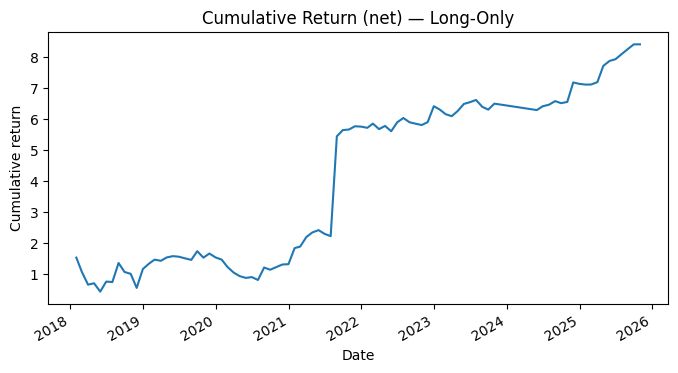

In [82]:
period = f'{net.index.min().date()} -> {net.index.max().date()}'
mdd_curve = net.cumsum()
dd = mdd_curve - mdd_curve.cummax()

print("Period:            ", period)
print("Ann. return (net): ", round(ann_ret(net), 3))
print("Ann. vol:          ", round(ann_vol(net), 3))
print("Sharpe (ann.):     ", round(sharpe_ann(net), 2))
print("Avg turnover:      ", round(turnover.mean(), 2))
print("Max drawdown:      ", round(dd.min(), 3))

mode_name = {
    "L": "Long-Only",
    "S": "Short-Only",
    "LS": "Long-Short",
}[METHOD]

ax = net.cumsum().plot(title=f"Cumulative Return (net) — {mode_name}", figsize=(8,4))
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative return")
plt.show()

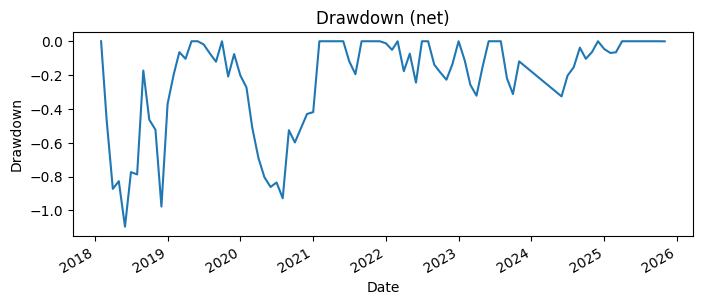

In [83]:
ax = dd.plot(title="Drawdown (net)", figsize=(8,3))
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
plt.show()

In [84]:
tag = {
    "L": "lo",
    "S": "so",
    "LS": "ls",
}[METHOD]
stem = SCORES_FILE.stem.replace(".parquet","").replace("scores_","")  # e.g., "scores_walkforward" → "walkforward"
run_name = f"{'ridge' if 'walkforward' in stem else 'xgb'}_{tag}_z{CLIP_Z:g}_c{int(COST_PER_DOLLAR*1e4)}bps"

out = {
    "weights": PROJECT_ROOT / f"data/weights_{run_name}.parquet",
    "pnl":     PROJECT_ROOT / f"data/pnl_{run_name}.parquet",
}

pd.DataFrame(W).to_parquet(out["weights"])
pd.DataFrame({"gross":gross, "net":net, "turnover":turnover}).to_parquet(out["pnl"])
print("Saved:", out)

Saved: {'weights': PosixPath('/Users/amanmeda/Documents/ml-pm-starter/data/weights_ridge_lo_z3_c10bps.parquet'), 'pnl': PosixPath('/Users/amanmeda/Documents/ml-pm-starter/data/pnl_ridge_lo_z3_c10bps.parquet')}


In [85]:
gross.tail(20)

2023-09-30   -0.092397
2023-10-31    0.193990
2024-05-31   -0.206024
2024-06-30    0.122929
2024-07-31    0.049967
2024-08-31    0.116797
2024-09-30   -0.065651
2024-10-31    0.040710
2024-11-30    0.628125
2024-12-31   -0.045042
2025-01-31   -0.022813
2025-02-28    0.004661
2025-03-31    0.075106
2025-04-30    0.524742
2025-05-31    0.159726
2025-06-30    0.056624
2025-07-31    0.165474
2025-08-31    0.162848
2025-09-30    0.153274
2025-10-31    0.000000
Name: gross, dtype: float64

In [86]:
gross.tail(12).mean()

0.1552271409523901

In [87]:
gross.tail(12).std()

0.21214802948307293

In [88]:
W.tail()

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042494,0.0,0.0,0.0,0.0,0.0
2025-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.084837,0.0,0.0,0.0,0.0,0.0


In [89]:
W.iloc[-1][W.iloc[-1] != 0]


Ticker
OMER    0.028540
QUBT    0.040650
URGN    0.207341
REPL    0.122516
MVST    0.016921
AEVA    0.136961
PRAX    0.336852
QBTS    0.006016
ACDC    0.019367
SEZL    0.084837
Name: 2025-10-31 00:00:00, dtype: float64